**Dataset (Fuente):** https://europepmc.org/article/med/29474911

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Entendimiento del Problema

Se requiere predecir si las personas presentan neumonía basados en una imagen de Rayos X del tórax. Para ello se tiene un dataset de imágenes de Rayos X  del tórax de pacientes que presentaron neumonía severa y de pacientes que no tuvieron.

Archivos

*   train.csv - The training set contiene los nombres de las imágenes que son utilizados para entrenar el modelo.
*   test.csv - The test set contiene los nombres de las imágenes que son utilizados para evaluar el modelo.



*   Objetivo principal
Determinar si una imagen de Rayos X  del Tórax presenta signos de neumonía severa.


*   Objetivos secundarios

o	 Analizar y realizar el preprocesamiento de las imágenes.

o	 Seleccionar el modelo y evaluar.

o	 Determinar la probabilidad en los datos de Test




In [6]:
!git clone https://github.com/iapucp/X-Ray-Pneumonia-Images.git

Cloning into 'X-Ray-Pneumonia-Images'...
remote: Enumerating objects: 5828, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 5828 (delta 0), reused 2 (delta 0), pack-reused 5826 (from 1)
Receiving objects: 100% (5828/5828), 1.13 GiB | 23.30 MiB/s, done.
Updating files: 100% (5856/5856), done.


In [ ]:
%ls

drive/  my_model/  sample_data/  X-Ray-Pneumonia-Images/


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

#Entendimiento de los Datos

In [2]:
#Lectura del dataset
df= pd.read_csv( "train.csv")
df_test= pd.read_csv("test_x.csv")

In [3]:
df

,Id,File_names,Target
0,0,e184d851-45d7-50ff-85a9-9b75993484e7.jpeg,0
1,1,6e2c95c7-c0c2-565a-b3e2-d9de6eeb72ce.jpeg,1
2,2,2b7ca495-6101-5fe1-9c35-3a37e98a0cf2.jpeg,1
3,3,9d5fdc1a-22ac-5a4b-9942-694fa403765c.jpeg,1
4,4,786806b0-55cd-5aa3-a5d8-66701ffd77f7.jpeg,1
...,...,...,...
4972,4972,51b329d9-633c-5a9b-a432-c11e5e3cd593.jpeg,1
4973,4973,666bd74a-49c9-503a-9e31-d26e15c02d8b.jpeg,1
4974,4974,e88647e1-5724-5ae9-a471-317ee2bb23f4.jpeg,1
4975,4975,afc768ab-78f8-5274-843f-889474e04a62.jpeg,0


Target
1    0.729757
0    0.270243
Name: count, dtype: float64


<Axes: >

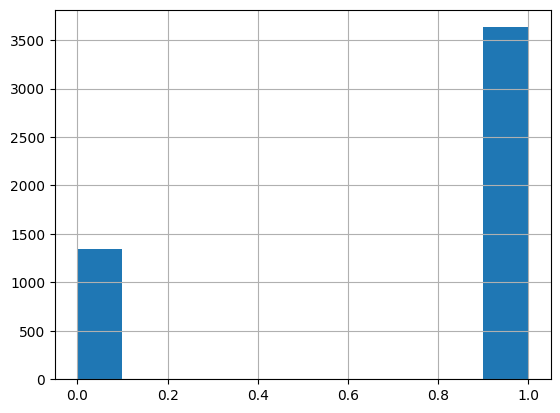

In [4]:
print(df["Target"].value_counts()/len(df))
df["Target"].hist()

Visualizando las imágenes

(1333, 1496, 3)


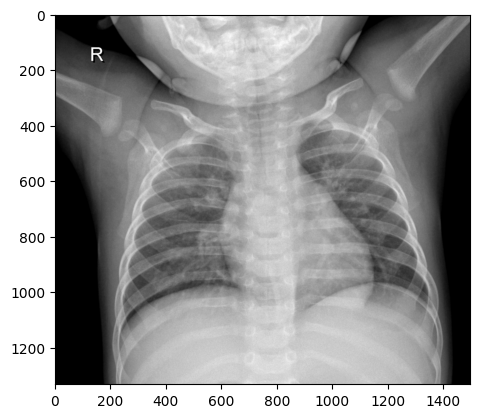

In [8]:
pathi="X-Ray-Pneumonia-Images/Images" + "/"
img = cv2.imread(pathi + df['File_names'].iloc[100])
print( img.shape)
plt.imshow(img)

(712, 992, 3)


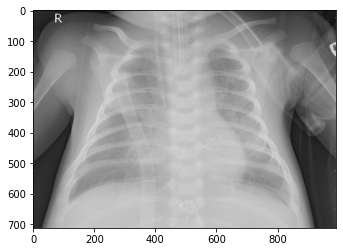

In [ ]:
img = cv2.imread(pathi + df['File_names'].iloc[1000])
print( img.shape)
plt.imshow(img)

#Preparación de los Datos

Función que permite leer las imágenes se observó que las imágenes tenian diferentes tamaños asi que se cambio el tamaño de todas las imágenes a 64x64 ó 128x128. También, las imágenes se normalizaron.

In [9]:
#Función que permite cargar leer las imágenes
def loadImagestrain(df):
    X = []
    Y = []
    mean = 0.5
    std = 0.5
    pathi="X-Ray-Pneumonia-Images/Images" + "/"
    for i in range(df.shape[0]):
        img_path = pathi + df['File_names'].iloc[i]
        img_label = df['Target'].iloc[i]
        img = cv2.imread(img_path)
        #print(i)
        img = img / 255.0
        img = (img - mean) / std
        img = cv2.resize(img, (128, 128))
        X.append(img)
        Y.append(img_label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X,Y


In [10]:
#Función que permite cargar leer las imágenes
def loadImagestest(df):
    X = []
    mean = 0.5
    std = 0.5
    pathi="X-Ray-Pneumonia-Images/Images" + "/"
    for i in range(df.shape[0]):
        img_path = pathi + df['File_names'].iloc[i]
        img = cv2.imread(img_path)
        #print(i)
        img = img / 255.0
        img = (img - mean) / std
        img = cv2.resize(img, (128, 128))
        X.append(img)
    X = np.asarray(X)
    return X

In [11]:
#Cargando las imágenes y etiquetas para el train
X,Y = loadImagestrain(df)
#Cargando las imágenes de Test para presentar en Kagle
Test_X = loadImagestest(df_test)

In [13]:
#Separando los datos de train y validación.
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=21)

#Generando el modelo

In [14]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(128,128,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,381,217 (12.90 MB)

 Trainable params: 3,381,217 (12.90 MB)

 Non-trainable params: 0 (0.00 B)

\

---



In [17]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(),metrics=[ 'accuracy','AUC'])

In [ ]:
%mkdir -p my_model

In [20]:
#Utlizando el checkpoint para encontrar los pesos considerando el mejor accuracy en validación.
checkpoint_path = "weights-improvement-{epoch:02d}-{val_accuracy:.3f}.weights.h5"

monitor = "val_accuracy"

mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [21]:
history = model.fit(X_train, y_train,batch_size=32,epochs=10,validation_data=(X_test, y_test), callbacks=[model_checkpoint])

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - AUC: 0.7908 - accuracy: 0.8049 - loss: 0.4673
Epoch 1: val_accuracy improved from -inf to 0.93876, saving model to weights-improvement-01-0.939.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 963ms/step - AUC: 0.7918 - accuracy: 0.8054 - loss: 0.4662 - val_AUC: 0.9838 - val_accuracy: 0.9388 - val_loss: 0.1633
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - AUC: 0.9770 - accuracy: 0.9404 - loss: 0.1608
Epoch 2: val_accuracy did not improve from 0.93876
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 961ms/step - AUC: 0.9770 - accuracy: 0.9404 - loss: 0.1608 - val_AUC: 0.9873 - val_accuracy: 0.8986 - val_loss: 0.2432
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - AUC: 0.9863 - accuracy: 0.9545 - loss: 0.1236
Epoch 3: val_accuracy improved from 0.93876 to 0.94478, saving model to weights-improvement-03-0.945.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 975ms/step - AUC: 0.9863 - accuracy: 0.9545 - loss: 0.1236 - val_AUC: 0.9902 - val

In [23]:
model.load_weights("weights-improvement-09-0.962.weights.h5")

In [26]:
model.save('chest_xrayV8.hdf5')

#Evaluando el modelo

In [24]:
score_train= model.evaluate(X_train, y_train)

125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 270ms/step - AUC: 0.9999 - accuracy: 0.9956 - loss: 0.0099


In [25]:
score_test= model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - AUC: 0.9855 - accuracy: 0.9629 - loss: 0.1519


In [27]:
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']

  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['accuracy'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

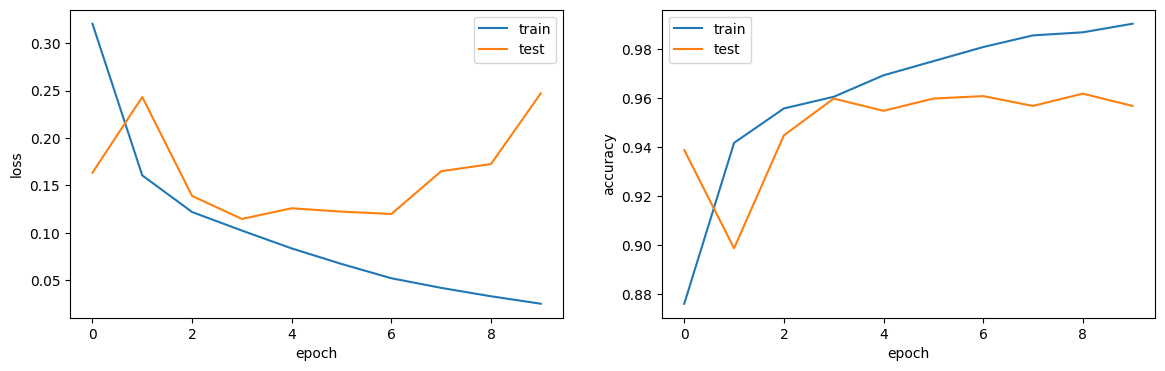

In [28]:
show_results(history)# Graficando el Loss y Accuracy vs Epoch

In [29]:
#Graficando el AUC
plt.plot(history.history['auc'], label = 'AUC')
plt.plot(history.history['val_auc'],label = 'val_AUC')
plt.legend()
plt.show()

KeyError: 'auc'

In [ ]:
#del model

In [ ]:
#model = tf.keras.models.load_model('drive/MyDrive/DeepLearning2022-2/EXAMENPARCIAL/models/chest_xrayV1.hdf5')

In [30]:
label_pre=(model.predict(X_test) > 0.5).astype("int32")

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step


In [31]:
#Generando la matrix de confusión y el Reporte de Calsificación
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test,label_pre),
                  index = ['NO','SI'],
                  columns = ['NO','SI'])
print("Confusion Matrix")
print(cm)
print('\n')
print("Reporte de clasificación")
print(classification_report(y_test, label_pre, digits=4))

Confusion Matrix
     NO   SI
NO  252   17
SI   21  706


Reporte de clasificación
              precision    recall  f1-score   support

           0     0.9231    0.9368    0.9299       269
           1     0.9765    0.9711    0.9738       727

    accuracy                         0.9618       996
   macro avg     0.9498    0.9540    0.9518       996
weighted avg     0.9621    0.9618    0.9619       996



In [32]:
#Guardando la Matriz de confusión, Reporte de clasificación y métricas evaluadas
output_log_file = os.path.join('report_chest_xrayV8.txt')
target_names=['NO','SI']
#Saving classification report
textf = open(output_log_file, "w")
print('Classification Report', file=textf)
print('\n', file=textf)
print('Confusion Matrix:', file=textf)
print(cm, file=textf)
print('\n', file=textf)
print('Classification Report', file=textf)
print(classification_report(y_test,label_pre,target_names=target_names,digits=4),file=textf)
print('\n', file=textf)
print('Train Loss','Test Loss' ,file=textf)
print('{0:.4g}'.format(score_train[0]),'{0:.4g}'.format(score_test[0]),file=textf)
print('\n', file=textf)
print('Train ACC','Test ACC' ,file=textf)
print('{0:.4g}'.format(score_train[1]),'{0:.4g}'.format(score_test[1]),file=textf)
print('\n', file=textf)
print('Train AUC','Test AUC' ,file=textf)
print('{0:.4g}'.format(score_train[2]),'{0:.4g}'.format(score_test[2]),file=textf)
print('\n', file=textf)


textf.close()

#Realizando las predicciones en el Test Set para Kaggle

In [ ]:
pred_kagle = model.predict(Test_X).flatten()
pred_kagle

In [ ]:
df_r1 = pd.DataFrame(pred_kagle, columns = ['Predicted'])
result = pd.concat([df_test['Id'], df_r1], axis=1)

In [ ]:
result

,Id,Predicted
0,0,9.996327e-01
1,1,9.998262e-01
2,2,1.197449e-06
3,3,1.000000e+00
4,4,9.999920e-01
...,...,...
874,874,1.659298e-06
875,875,2.749551e-07
876,876,9.996533e-01
877,877,9.999577e-01


In [ ]:
#result.to_csv("drive/MyDrive/DeepLearning2022-2/EXAMENPARCIAL/result/resultV7.csv", sep=",", index=False, header=True)

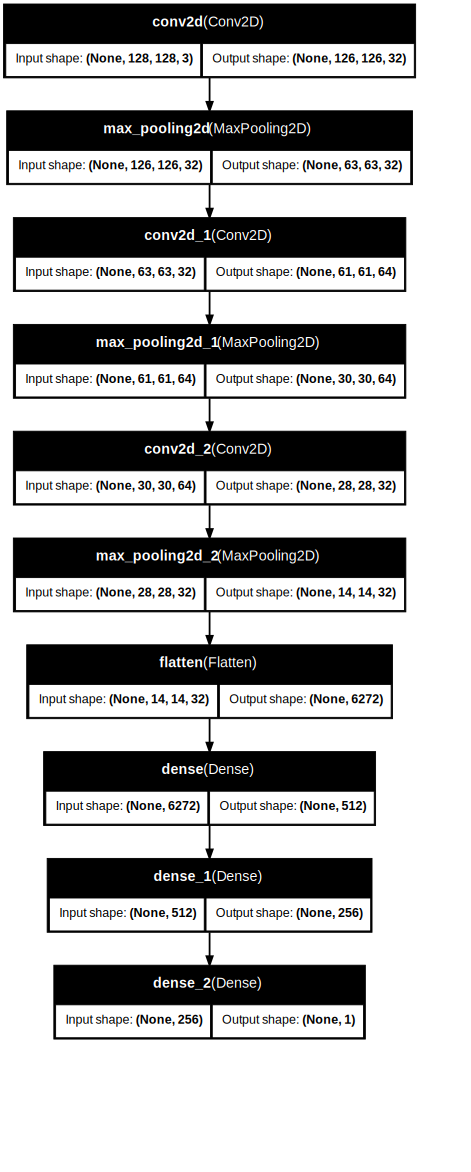

In [33]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from pprint import pprint

SVG(model_to_dot(model, show_shapes=True, dpi=64).create(prog='dot', format='svg'))